In [1]:
%matplotlib inline
from stack_nlp import *
from jupyter_mplsettings import *
matplotlib.rc('font', **font)

Using TensorFlow backend.


In [2]:
cfg = local_import("./laptop.py")
cfg.options["read"] = ["questions", "features", "answers"]

In [3]:
PrepareData(cfg)
data = cfg.data
data.keys()
qs = data["meta"]
conn = data["dbconn"]
ans = data["answers"]

Using meta path: /home/alex/data/stackexchange/overflow/caches/posts_2017.hdf5
Shape of question df (1696819, 21)
Shape of merged question df (1000000, 34)
Selecting only questions with at least 5 meaningful words.
This removes 8582 questions.
Removing bad values with missing feature information.
This affects 19 questions.
Shape of answer df (2028240, 21)
Calculating normalized columns. They are available under usual column name + _norm.


## Quantiles for ad-hoc features

In [25]:
features = ["BodyNCodes", "BodyNQMarks", "BodySize", "titlelen", "nwords", "ordersum", "ordermean", "orderstd", "ratio"]
allquants = {}
allquants["quants"] = np.asfarray([0.1, 0.3, 0.5, 0.7, 0.9])
for feature in features:
    allquants[feature] = mquantiles(qs[qs.Score >= 1][feature], prob=np.asfarray([0.1, 0.3, 0.5, 0.7, 0.9]))

In [30]:
qdf = pd.DataFrame(allquants).T
print qdf
# qdf.loc["BodyNCodes"]
qdf.to_csv("./feature_quantiles.csv")

                       0             1             2             3  \
BodyNCodes      0.000000      1.000000      2.000000      3.000000   
BodyNQMarks     0.000000      1.000000      1.000000      1.000000   
BodySize      411.000000    740.000000   1119.000000   1715.000000   
nwords         15.000000     24.000000     34.000000     48.000000   
ordermean     396.738261    737.250789   1051.666667   1408.940706   
orderstd      572.492499   1326.135833   2248.730039   3136.626325   
ordersum     6126.000000  15541.000000  25766.000000  39341.940000   
quants          0.100000      0.300000      0.500000      0.700000   
ratio           0.250000      0.370370      0.466667      0.583333   
titlelen       32.000000     43.000000     52.000000     63.000000   

                        4  
BodyNCodes       7.000000  
BodyNQMarks      3.000000  
BodySize      3365.000000  
nwords          78.000000  
ordermean     2033.221746  
orderstd      4512.474751  
ordersum     66589.140000  
quant

## Post scores

In [4]:
# checking scores
print qs.Score.describe()
print ans.Score.describe()

count    991399.000000
mean          0.376745
std           1.782727
min         -59.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         427.000000
Name: Score, dtype: float64
count    2.028240e+06
mean     7.977586e-01
std      2.100873e+00
min     -1.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.270000e+02
Name: Score, dtype: float64


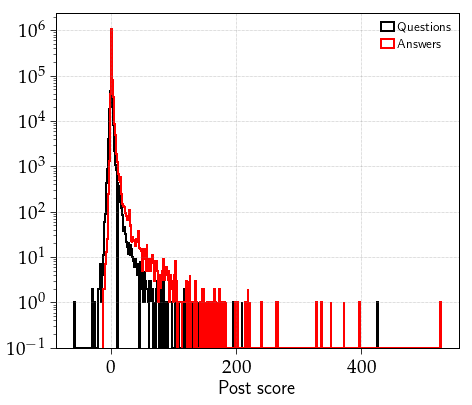

In [7]:
plt.figure(figsize=(8, 6))
plt.xlabel("Post score")
plt.ylabel("Counts per bin")
qs.Score.hist(range=[qs.Score.min(), qs.Score.max()], bins=500, histtype="step", color="k", lw=2, log=True, label="Questions")
ans.Score.hist(range=[ans.Score.min(), ans.Score.max()], bins=500, histtype="step", color="r", lw=2, log=True, label="Answers")
plt.legend(loc="upper right")

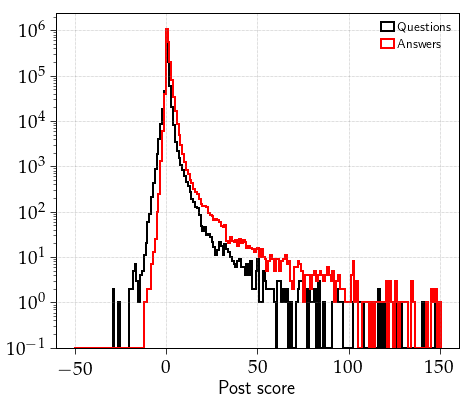

In [5]:
plt.figure(figsize=(8, 6))
plt.xlabel("Post score")
plt.ylabel("Counts per bin")
qs.Score.hist(range=[-50.5, 150.5], bins=200, histtype="step", color="k", lw=2, log=True, label="Questions")
ans.Score.hist(range=[-50.5, 150.5], bins=200, histtype="step", color="r", lw=2, log=True, label="Answers")
plt.legend(loc="upper right")

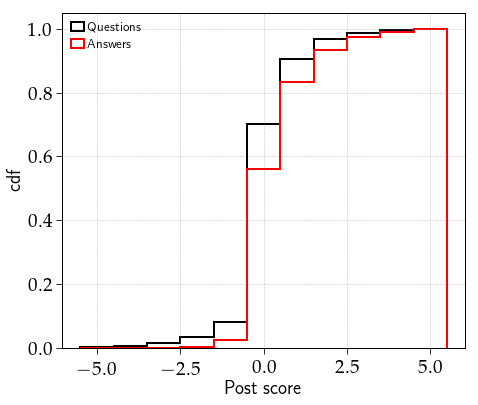

In [14]:
plt.figure(figsize=(8, 6))
plt.xlabel("Post score")
plt.ylabel("cdf")
qs.Score.hist(range=[-5.5, 5.5], bins=11, histtype="step", color="k", lw=2, cumulative=True, normed=True, label="Questions")
ans.Score.hist(range=[-5.5, 5.5], bins=11, histtype="step", color="r", lw=2, cumulative=True, normed=True, label="Answers")
plt.legend(loc="upper left")

In [16]:
print np.sum(qs.Score > 0) * 1. / len(qs)
print np.sum(qs.Score < 0) * 1. / len(qs)
print np.sum(qs.Score == 0) * 1. / len(qs)

0.302160885779
0.0823755117768
0.615463602445


In [25]:
print np.sum(ans.Score > 0) * 1. / len(ans)
print np.sum(ans.Score < 0) * 1. / len(ans)
print np.sum(ans.Score == 0) * 1. / len(ans)

0.446425472331
0.0231589949907
0.530415532679


## Number of favorites

In [19]:
qs.loc[qs.FavoriteCount == -1, "FavoriteCount"] = 0
ans.loc[ans.FavoriteCount == -1, "FavoriteCount"] = 0
print qs.FavoriteCount.describe()
print ans.FavoriteCount.describe()

count    991399.000000
mean          0.107513
std           0.453435
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          82.000000
Name: FavoriteCount, dtype: float64
count    2.028240e+06
mean     2.465191e-06
std      1.570091e-03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: FavoriteCount, dtype: float64


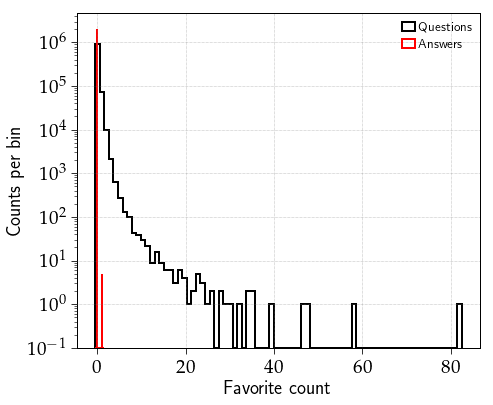

In [29]:
plt.figure(figsize=(8, 6))
plt.xlabel("Favorite count")
plt.ylabel("Counts per bin")
qs.FavoriteCount.hist(range=[qs.FavoriteCount.min() - 0.5, qs.FavoriteCount.max() + 0.5], bins=80, histtype="step", color="k", lw=2, log=True, label="Questions")
ans.FavoriteCount.hist(range=[ans.FavoriteCount.min() - 0.5, ans.FavoriteCount.max() + 0.5], bins=80, histtype="step", color="r", lw=2, log=True, label="Answers")
plt.legend(loc="upper right")

In [30]:
print np.sum(qs.FavoriteCount > 0) * 1. / len(qs)
print np.sum(qs.FavoriteCount == 0) * 1. / len(qs)

0.0864001274966
0.913599872503


## Number of views

In [28]:
qs.loc[qs.ViewCount == -1, "ViewCount"] = 0
ans.loc[ans.ViewCount == -1, "ViewCount"] = 0
print qs.ViewCount.describe()
print ans.ViewCount.describe()

count    991399.000000
mean        125.955318
std         422.538571
min           2.000000
25%          34.000000
50%          55.000000
75%         105.000000
max       68872.000000
Name: ViewCount, dtype: float64
count    2.028240e+06
mean     2.303968e-03
std      6.369627e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.340000e+02
Name: ViewCount, dtype: float64


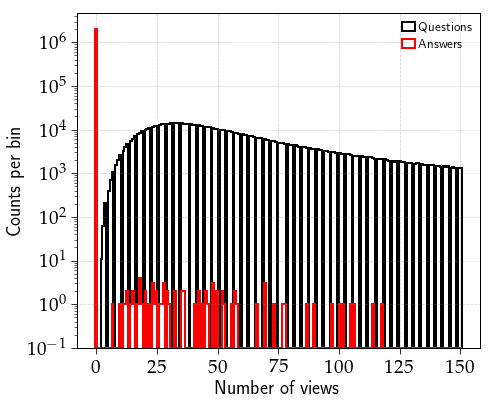

In [31]:
plt.figure(figsize=(8, 6))
plt.xlabel("Number of views")
plt.ylabel("Counts per bin")
qs.ViewCount.hist(range=[-0.5, 150.5], bins=200, histtype="step", color="k", lw=2, log=True, label="Questions")
ans.ViewCount.hist(range=[-0.5, 150.5], bins=200, histtype="step", color="r", lw=2, log=True, label="Answers")
plt.legend(loc="upper right")

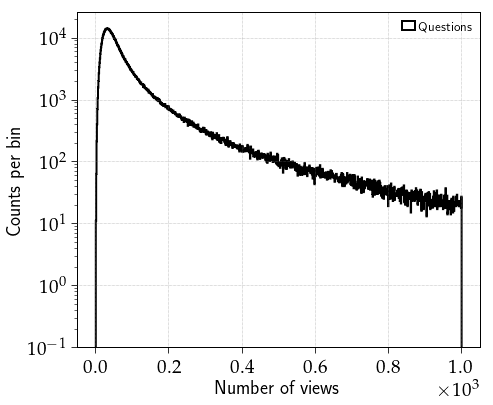

In [32]:
plt.figure(figsize=(8, 6))
plt.xlabel("Number of views")
plt.ylabel("Counts per bin")
qs.ViewCount.hist(range=[-0.5, 1000.5], bins=1001, histtype="step", color="k", lw=2, log=True, label="Questions")
plt.legend(loc="upper right")

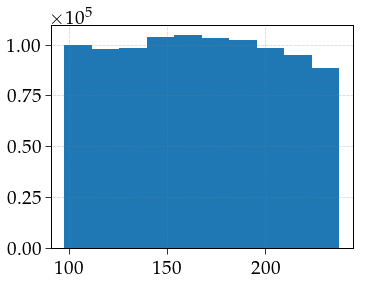

In [34]:
qs.dt_created_day.hist()

In [35]:
qs["viewsperday"] = qs.ViewCount * 1. / qs.dt_created_day

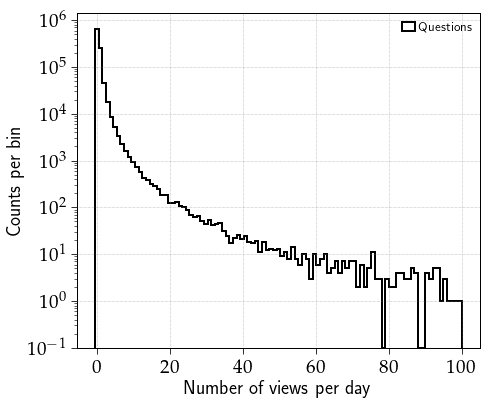

In [38]:
plt.figure(figsize=(8, 6))
plt.xlabel("Number of views per day")
plt.ylabel("Counts per bin")
qs.viewsperday.hist(range=[-0.5, 100], bins=101, histtype="step", color="k", lw=2, log=True, label="Questions")
plt.legend(loc="upper right")

(0, 200)

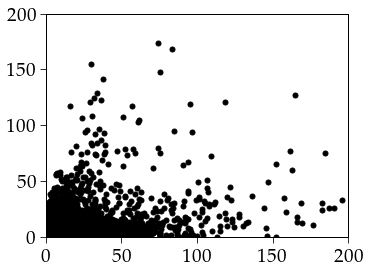

In [41]:
plt.plot(qs.viewsperday, qs.Score, "k.")
plt.xlim(0, 200)
plt.ylim(0, 200)

(0, 200)

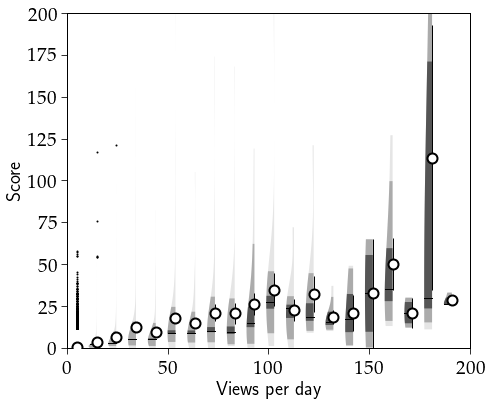

In [44]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Views per day")
plt.ylabel(r"Score")
QuickSlicePlot(qs.viewsperday, qs.Score, qs.Score, zbins=1, xRange=[0, 200], xbins=20, yrange=[0, 200], axes=plt.gca())
plt.xlim(0, 200)

In [70]:
qsgood = qs[np.isfinite(qs.dt_accanswer_hour) & qs.dt_accanswer_hour > 0]
qsfirst = qs[np.isfinite(qs.dt_answer_hour) & qs.dt_answer_hour > 0]

In [71]:
print qs.shape
print qsgood.shape
print qsfirst.shape

(991399, 56)
(385781, 56)
(704120, 56)


(0, 200)

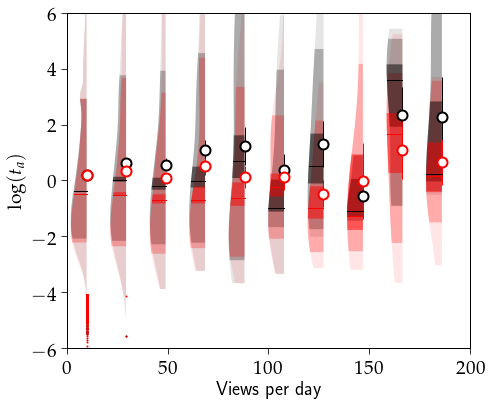

In [72]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Views per day")
plt.ylabel(r"$ \log(t_a) $")
QuickSlicePlot(qsgood.viewsperday, qsgood.dt_accanswer_hour.apply(np.log), qsgood.Score, 
               zbins=1, xRange=[0, 200], xbins=10, yrange=[-6, 6], color="k", axes=plt.gca())
QuickSlicePlot(qsfirst.viewsperday, qsfirst.dt_answer_hour.apply(np.log), qsfirst.Score, 
               zbins=1, xRange=[0, 200], xbins=10, yrange=[-6, 6], color="r", axes=plt.gca())
plt.xlim(0, 200)

(-20, 100)

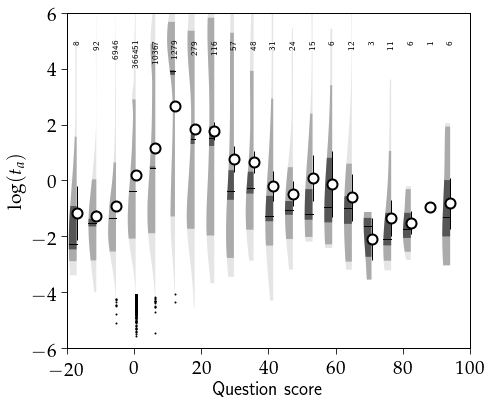

In [78]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Question score")
plt.ylabel(r"$ \log(t_a) $")
QuickSlicePlot(qsgood.Score, qsgood.dt_accanswer_hour.apply(np.log), qsgood.Score, 
               zbins=1, xRange=[-20, 100], xbins=20, yrange=[-6, 6], color="k", draw="amvc", axes=plt.gca(),
               textpos=5)
# QuickSlicePlot(qsfirst.Score, qsfirst.dt_accanswer_hour.apply(np.log), qsfirst.Score, 
#                zbins=1, xRange=[-20, 100], xbins=20, yrange=[-6, 6], color="r", axes=plt.gca())
plt.xlim(-20, 100)

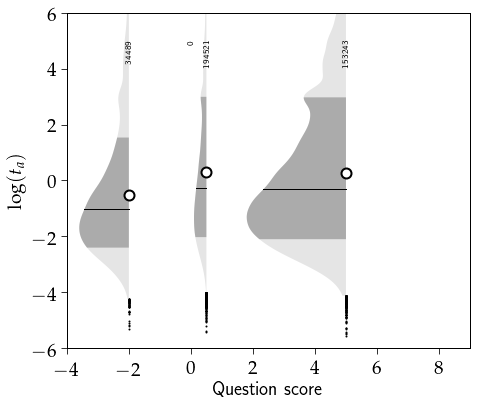

In [90]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Question score")
plt.ylabel(r"$ \log(t_a) $")
mask = (qsgood.Score > -5) & (qsgood.Score < 10)
QuickSlicePlot(qsgood[mask].Score, qsgood[mask].dt_accanswer_hour.apply(np.log), qsgood[mask].Score, 
               zbins=1, xbins=mquantiles(qsgood[mask].Score, prob=np.linspace(0, 1, 5)), 
               yrange=[-6, 6], color="k", draw="amvc", axes=plt.gca(),
               textpos=5);
# QuickSlicePlot(qsfirst.Score, qsfirst.dt_accanswer_hour.apply(np.log), qsfirst.Score, 
#                zbins=1, xRange=[-20, 100], xbins=20, yrange=[-6, 6], color="r", axes=plt.gca())
# plt.xlim(-5, 20)

## Number of answers

In [63]:
qs.AnswerCount.describe()

count    991399.000000
mean          1.050494
std           0.969348
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          26.000000
Name: AnswerCount, dtype: float64

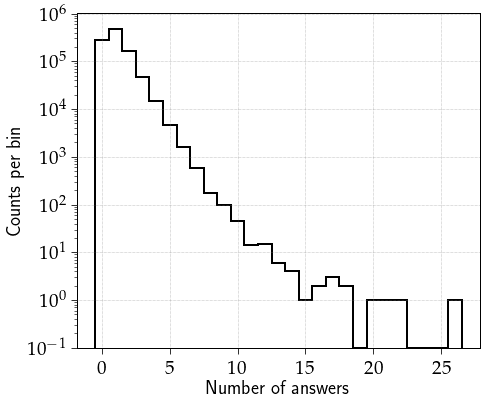

In [65]:
plt.figure(figsize=(8, 6))
plt.xlabel("Number of answers")
plt.ylabel("Counts per bin")
qs.AnswerCount.hist(range=[-0.5, 26.5], bins=27, histtype="step", color="k", lw=2, log=True, label="Questions");

In [69]:
print np.sum(qs.AnswerCount == 0) * 1. / len(qs)
print np.sum(qs.AnswerCount == 1) * 1. / len(qs)
print np.sum(qs.AnswerCount > 1) * 1. / len(qs)

0.287141705812
0.479765462745
0.233092831443
